## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to a desired target state ($\ket{1}, \ket{+}$ or $\ket{-}$) by applying a rotational quantum gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [172]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Union

from scipy.stats import norm
from scipy.linalg import sqrtm

import torch
import torch.distributions.normal as Normal
import torch.optim as optim

from braket.circuits import Circuit
from braket.devices import LocalSimulator

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), we can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\ket{1}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\ket{1}$).
- The outcome of the measurement is then in the Hadamard basis.

In [173]:
def get_dm(state: np.ndarray) -> np.ndarray:
    return np.outer(state, np.conj(state))

def get_fidelity(rho, sigma):
    """
    Compute the fidelity between two quantum states represented by density matrices.
    
    Parameters:
    - rho (numpy.ndarray): Density matrix of the first quantum state.
    - sigma (numpy.ndarray): Density matrix of the second quantum state.
    
    Returns:
    - float: Fidelity between the two quantum states.
    
    Note:
    This function assumes that the input density matrices are valid (positive, trace 1) and of the same size.
    """
    
    # Computing the square root of rho
    sqrt_rho = sqrtm(rho)
    
    # Calculating the product sqrt_rho * sigma * sqrt_rho
    temp_product = np.dot(np.dot(sqrt_rho, sigma), sqrt_rho)
    
    # Taking the square root of the product
    root_product = sqrtm(temp_product)
    
    # Calculating the trace and squaring it
    fidelity = np.real(np.trace(root_product))**2
    
    return fidelity

"""def estimate_dm(qc, estimated_dm, batch) -> np.ndarray:
    # Construct the estimated density matrix
    q_state = qi.Statevector.from_instruction(qc)
    estimated_dm += np.array(q_state.to_operator()) / batch 

    return estimated_dm"""

This algorithm is implemented for the following target states:

In [174]:
target_states = {
    '1': np.array([0, 1]),
    '+': (1/np.sqrt(2)) * np.array([+1, +1]),
    '-': (1/np.sqrt(2)) * np.array([+1, -1]),
}

### Define a target state

In [175]:
# Choose from '1', '+' or '-'
target_state_str = '1'

target_state = target_states[target_state_str]
print('Target state:', target_state)

Target state: [0 1]


In [176]:
def perform_action(amp: Union[torch.Tensor, np.array], shots=1, target_state_str=target_state_str):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, device, target_states
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    estimated_dm = np.zeros([2, 2], dtype='complex128')

    for ind, angle in enumerate(angles):
        qc = Circuit()
        if target_state_str == '1':
            qc.rx(0, 2 * np.pi * angle)  # Add parametrized gate for each amplitude in the batch
            # estimate_dm(qc, estimated_dm, batch)
            
        elif target_state_str in ['+', '-']:
            qc.ry(0, 2 * np.pi * angle)  # Add parametrized gate for each amplitude in the batch  
            # estimate_dm(qc, estimated_dm, batch)
            qc.h(0) # Transform to hadamard basis before measurement
        
        # Running the circuit
        task = device.run(qc, shots=shots)
        result = task.result()
        counts = result.measurement_counts  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key
        
        # Calculate reward
        if target_state_str == '1':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target_state_str == '+':
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))
        elif target_state_str == '-':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        else:
            if ind % 10 == 0:
                print('Reward calculation FAILS')

    return reward_table #, estimated_dm

#### Set Hyperparameters for the RL

In [177]:
# Define the local simulator
device = LocalSimulator()

seed = 2364

# Hyperparameters for the agent
n_epochs = 100
batch_size = 50

# Use Proximal Policy Optimization (PPO)?
use_PPO = True

eta = 0.1  # Learning rate for policy update step
critic_loss_coeff = 0.5

epsilon = 0.2  # Parameter for ratio clipping value (PPO)
grad_clip = 0.3
sigma_eps = 1e-6

Policy Parameters (From a Gaussian Distribution)

In [178]:
mu = torch.nn.Parameter(torch.randn([]) * 0.05, requires_grad=True)
mu_old = torch.clone(mu).detach().requires_grad_(False)

sigma = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)
sigma_old = torch.clone(sigma).detach().requires_grad_(False)

b = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)

print('Initial Parameters')
print('-------------------------')
print('\nmu: ', mu.item())
print('sigma: ', sigma.item())
print('b: ', b.item())

Initial Parameters
-------------------------

mu:  -0.07078706473112106
sigma:  1.0
b:  0.0


In [179]:
optimizer_string = "Adam"

# Define the optimizer based on optimizer_string
if optimizer_string == "Adam":
    optimizer = optim.Adam([mu, sigma, b], lr=eta)
elif optimizer_string == "SGD":
    optimizer = optim.SGD([mu, sigma, b], lr=eta)

Value Constrains for the Gaussian Policy Parameters

In [180]:
def constrain_mu(value):
    return torch.clamp(value, -1., +1.)

def constrain_sigma(value):
    return torch.clamp(value, sigma_eps, 1.5)

Keeping track of all variables

In [181]:
#  Keep track of variables
params = {
    "means": np.zeros(n_epochs),
    "stds": np.zeros(n_epochs),
    "amps": np.zeros([n_epochs, batch_size]),
    "rewards": np.zeros([n_epochs, batch_size]),
    "critic_loss": np.zeros(n_epochs),
    "fidelity": np.zeros(n_epochs),
    "grads": np.zeros((n_epochs, 3)),
    "hyperparams": {
        "learning_rate": eta,
        "seed": seed,
        "clipping_PPO": epsilon,
        "grad_clip_value": grad_clip,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "target_state": (target_state_str, target_states[target_state_str]),
        "PPO?": use_PPO,
        "critic_loss_coeff": critic_loss_coeff,
        "optimizer": optimizer_string

    }
}

#### Training

In [182]:
# Logging of intermediate Training Results
def log_info(epoch, mu, sigma, reward, target_state):
    print('\nEPOCH', epoch+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())
    print('Average Return:', reward.mean().item())
    print(f'Target state: |{target_state}>')
    # print('Fidelity: ', fidelity)

In [183]:
for epoch in tqdm(range(n_epochs)):
    normal_distrib = Normal.Normal(mu, sigma)
    normal_distrib_old = Normal.Normal(mu_old, sigma_old)
    a = normal_distrib.sample((batch_size,))

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    # reward, dm_observed = perform_action(a, shots=1, target_state_str=target_state_str)
    reward = perform_action(a, shots=1, target_state_str=target_state_str)

    optimizer.zero_grad()

    advantage = torch.tensor(reward) - b
    if use_PPO:
        ratio = normal_distrib.log_prob(a).exp() / (normal_distrib_old.log_prob(a).exp() + sigma_eps)
        clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
        actor_loss = - torch.mean(torch.min(advantage * ratio, advantage * clipped_ratio))
    else:  # REINFORCE algorithm
        log_probs = normal_distrib.log_prob(a)
        actor_loss = - torch.mean(advantage * log_probs)

    critic_loss = torch.mean(advantage ** 2)

    combined_loss = actor_loss + critic_loss_coeff * critic_loss
    combined_loss.backward()

    # Clipping gradients (if needed)
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)

    # Apply constraints on mu and sigma
    mu.data = constrain_mu(mu.data)
    sigma.data = constrain_sigma(sigma.data)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.data = mu.data.clone()
        sigma_old.data = sigma.data.clone()

    # Apply gradients
    optimizer.step()

    params["amps"][epoch] = np.array(a.cpu().detach())
    params["rewards"][epoch] = reward
    params["means"][epoch] = np.array(mu.item())
    params["stds"][epoch] = np.array(sigma.item())
    params["critic_loss"][epoch] = np.array(critic_loss.cpu().detach())
    # params["fidelity"][epoch] = get_fidelity(get_dm(target_states[target_state_str]), dm_observed)
    params["grads"][epoch] = np.array([param.grad for param in [mu, sigma, b]])

    # Log intermediate results of the training process
    if epoch % 10 == 0:
        # log_info(epoch, mu, sigma, reward, target_state_str, params["fidelity"][epoch])
        log_info(epoch, mu, sigma, reward, target_state_str)

  3%|▎         | 3/100 [00:00<00:10,  8.89it/s]


EPOCH 1
Policy parameter
mu = 0.029212892055511475 +- sigma = 0.9000000357627869
baseline -0.10000000149011612
Average Return: 0.0
Target state: |1>


 13%|█▎        | 13/100 [00:01<00:07, 12.16it/s]


EPOCH 11
Policy parameter
mu = 0.2984798848628998 +- sigma = 0.28915584087371826
baseline -1.0497817993164062
Average Return: 0.0
Target state: |1>


 23%|██▎       | 23/100 [00:01<00:06, 12.32it/s]


EPOCH 21
Policy parameter
mu = 0.47168129682540894 +- sigma = 0.05069718509912491
baseline -1.3452398777008057
Average Return: 0.88
Target state: |1>


 33%|███▎      | 33/100 [00:02<00:05, 12.19it/s]


EPOCH 31
Policy parameter
mu = 0.44627583026885986 +- sigma = 0.003028525970876217
baseline -1.335800290107727
Average Return: 0.96
Target state: |1>


 43%|████▎     | 43/100 [00:03<00:04, 12.21it/s]


EPOCH 41
Policy parameter
mu = 0.46958425641059875 +- sigma = 0.008583031594753265
baseline -1.2843186855316162
Average Return: 0.84
Target state: |1>


 53%|█████▎    | 53/100 [00:04<00:03, 12.42it/s]


EPOCH 51
Policy parameter
mu = 0.4618535041809082 +- sigma = 0.017176594585180283
baseline -1.2145733833312988
Average Return: 0.96
Target state: |1>


 63%|██████▎   | 63/100 [00:05<00:02, 12.55it/s]


EPOCH 61
Policy parameter
mu = 0.4683220684528351 +- sigma = 0.007080559618771076
baseline -1.143049955368042
Average Return: 0.96
Target state: |1>


 73%|███████▎  | 73/100 [00:06<00:02, 12.64it/s]


EPOCH 71
Policy parameter
mu = 0.48683321475982666 +- sigma = 0.014101510867476463
baseline -1.0672518014907837
Average Return: 1.0
Target state: |1>


 83%|████████▎ | 83/100 [00:06<00:01, 12.53it/s]


EPOCH 81
Policy parameter
mu = 0.4825545847415924 +- sigma = 0.006526197772473097
baseline -0.9901422262191772
Average Return: 1.0
Target state: |1>


 93%|█████████▎| 93/100 [00:07<00:00, 12.59it/s]


EPOCH 91
Policy parameter
mu = 0.49982699751853943 +- sigma = 0.01171902846544981
baseline -0.9205417633056641
Average Return: 1.0
Target state: |1>


100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


#### Visualization

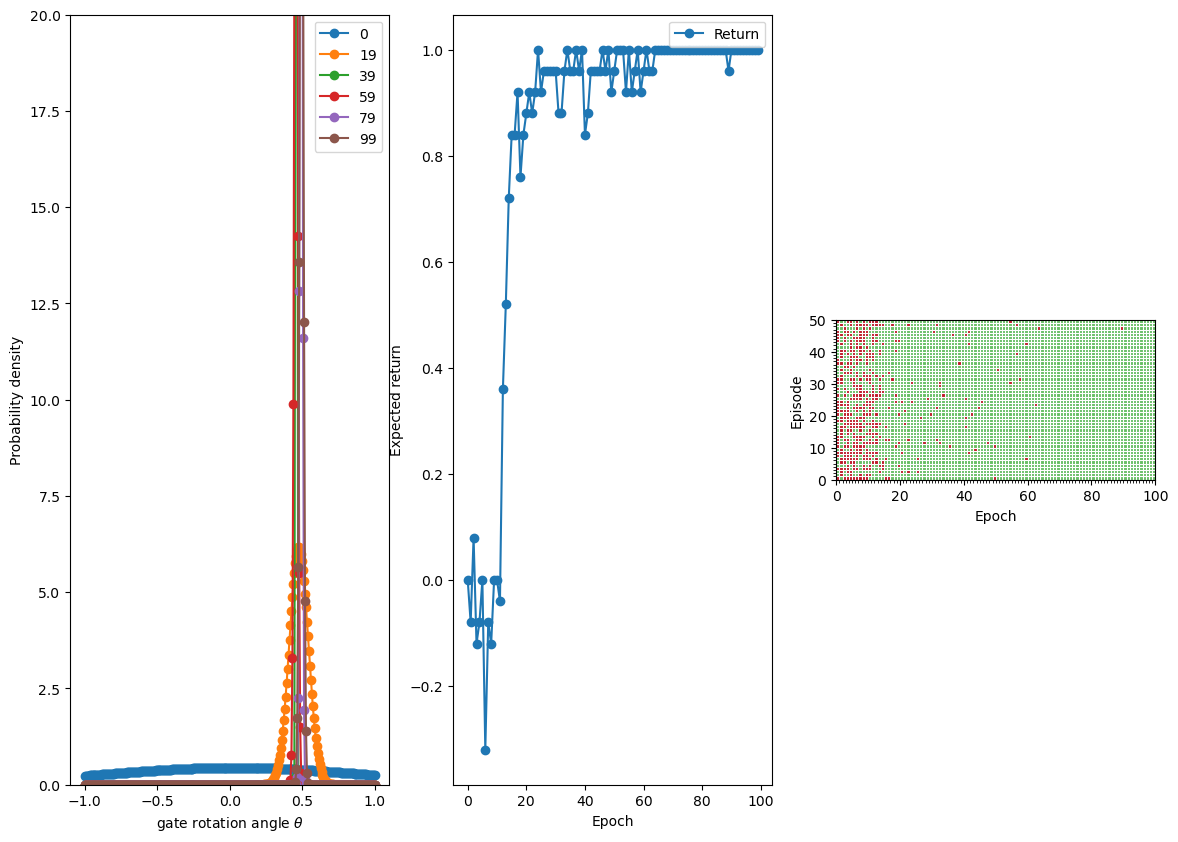

In [184]:
#  Plotting results
def plot_examples(ax, reward_table):
    """
    Helper function to plot data with associated colormap, used for plotting the reward per each epoch and each episode
    (From original repo associated to the paper https://github.com/v-sivak/quantum-control-rl)
    """

    vals = np.where(reward_table == 1, 0.6, -0.9)

    ax.pcolormesh(np.transpose(vals), cmap='RdYlGn', vmin=-1, vmax=1)

    ax.set_xticks(np.arange(0, vals.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(0, vals.shape[1], 1), minor=True)
    ax.grid(which='both', color='w', linestyle='-')
    ax.set_aspect('equal')
    ax.set_ylabel('Episode')
    ax.set_xlabel('Epoch')
    plt.show()


x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 10))
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, 6, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["means"][i], scale=np.abs(params["stds"][i])), '-o', label=f'{i}')

ax1.set_xlabel(r"gate rotation angle $\theta$")
ax1.set_ylabel("Probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["rewards"], axis=1), '-o', label='Return')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Expected return")
# ax2.plot(data["critic_loss"], '-.', label='Critic Loss')
# ax2.plot(params["fidelity"], '-o', label=f'State Fidelity (target: |{target_state_str}>)', color='green')
ax2.legend()
ax1.legend()
plot_examples(ax3, params["rewards"])

Evolvment of Training Parameters during the Training Process

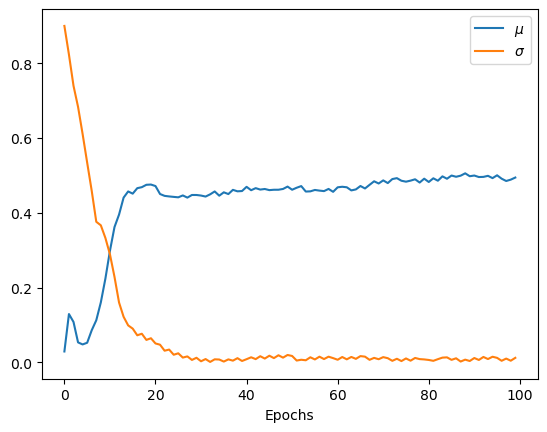

In [185]:
plt.plot(np.arange(0, n_epochs), params["means"], label=r'$\mu$')
plt.plot(np.arange(0, n_epochs), np.abs(params["stds"]), label=r'$\sigma$')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Final Gaussian Policy Parameters

Final mu =  0.49444
Final sigma =  0.012209
-------------------------------



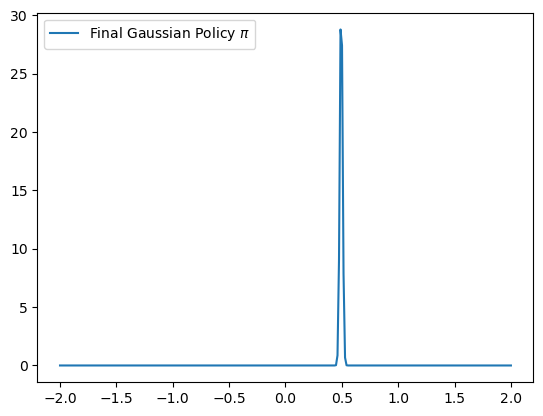

In [186]:
final_mu = params["means"][-1]
final_sigma = np.abs(params["stds"][-1])
print('Final mu = ', round(final_mu, 6))
print('Final sigma = ', round(final_sigma, 6))
print('-------------------------------\n')
      
x = np.linspace(-2., 2., 300)
plt.plot(x, norm.pdf(x, loc=final_mu, scale=final_sigma), label=r'Final Gaussian Policy $\pi$')
plt.legend()
plt.show()